In [ ]:

final.columns
final2 = final.iloc[:,[0,1,2,3,7]]
final2.columns = ['count', 'Distance(mi)', 'Duration_Time','Severity','Transport']

sns.scatterplot(x = final[('count','Severity')], y = final[('Transport', 'Transport')])

sns.pairplot(final2)

final2.corr()

final2["ratio"] = final2["Transport"]/final2["count"]

final2

pd.set_option('display.max_rows', 500)

final2.reset_index().groupby(["State","year"])["ratio"].mean().sort_values(ascending=False)

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

In [ ]:
full = pd.read_csv('../data/US_Accidents_June20.csv')

raw_df=full[full.Severity >= 3] 

raw_df['month'] = pd.to_datetime(raw_df.Start_Time).dt.month
raw_df['year'] = pd.to_datetime(raw_df.Start_Time).dt.year.astype(str).str[-2:]

In [ ]:
transport_df = pd.read_csv("../data/transport.csv")
transport_df.set_index('Code', inplace=True)
transport_df.drop('Abbrev', axis=1, inplace=True)
transport_df.index.name = 'State'

temp_columns = [cnt.split('.') for cnt in transport_df.columns]
change_month_key = {v.lower(): k for k,v in enumerate(calendar.month_abbr)}
for index, data in enumerate(temp_columns):
    temp_columns[index] = [data[0],change_month_key.get(data[1])]
transport_df.columns = pd.MultiIndex.from_tuples(temp_columns, names=['year', 'month'])
transport_code = transport_df.stack(['year','month'])
transport_code.name = ('Transport','Transport')
raw_df['Duration_Time'] = pd.to_datetime(raw_df['End_Time']) - pd.to_datetime(raw_df['Start_Time'])
raw_df['Duration_Time'] = raw_df['Duration_Time'].dt.seconds/60
table = raw_df.pivot_table(index=['State', 'year', 'month'], values=['Severity', 'Duration_Time', 'Distance(mi)'], aggfunc=['count', 'mean', 'sum'])\
    .drop([('count',  'Distance(mi)'), ('count', 'Duration_Time')], axis=1)

final_s3 = pd.merge(table, transport_code, left_index=True, right_index=True,how='left')

In [145]:
data = final_s3.copy().iloc[:,[0,1,2,3,7]]

In [146]:
# data = pd.read_csv('../data/final.csv',index_col=[0,1,2],header=[0,1]).iloc[:,[0,1,2,3,7]]
data.columns = ['count', 'Distance(mi)', 'Duration_Time','Severity','Transport']
data["ratio"] =  data["count"]/data["Transport"]

In [147]:
final = data.copy().reset_index()
final = final[~((final["year"] == 20) & (final["month"] == 6))]
final["date"] = final["year"].astype(str) + "-" + final["month"].astype(str)
final = final.sort_values(["year", "month"])

In [148]:
s = data.reset_index().groupby("State")["count"].sum().rank(ascending = False)
s =  s < 16
index = s.index[s]

final2 = final[final["State"].isin(index)]

In [149]:
data.corr()

,count,Distance(mi),Duration_Time,Severity,Transport,ratio
count,1.000000,-0.149664,-0.254566,-0.313856,0.876814,0.502871
Distance(mi),-0.149664,1.000000,0.160521,0.355422,-0.170945,-0.214999
Duration_Time,-0.254566,0.160521,1.000000,0.631707,-0.141992,-0.428176
Severity,-0.313856,0.355422,0.631707,1.000000,-0.275300,-0.426510
Transport,0.876814,-0.170945,-0.141992,-0.275300,1.000000,0.271414
ratio,0.502871,-0.214999,-0.428176,-0.426510,0.271414,1.000000


<AxesSubplot:xlabel='date', ylabel='Transport'>

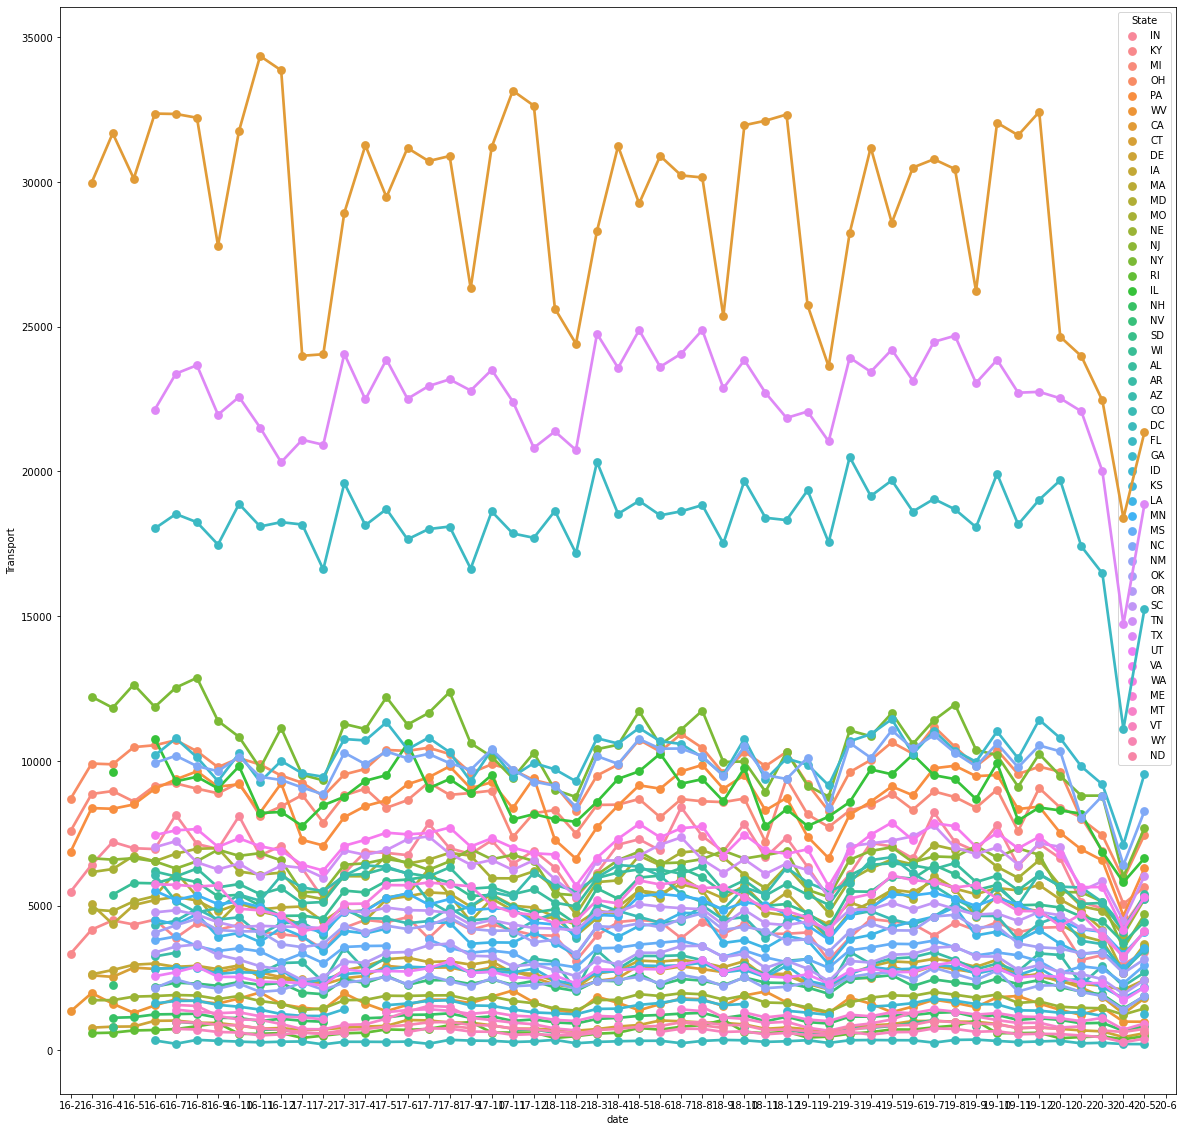

In [153]:
plt.figure(figsize=(20, 20))

sns.pointplot(data = final, x = "date", y = "Transport", hue = "State",err_style=None)

(0.0, 10000.0)

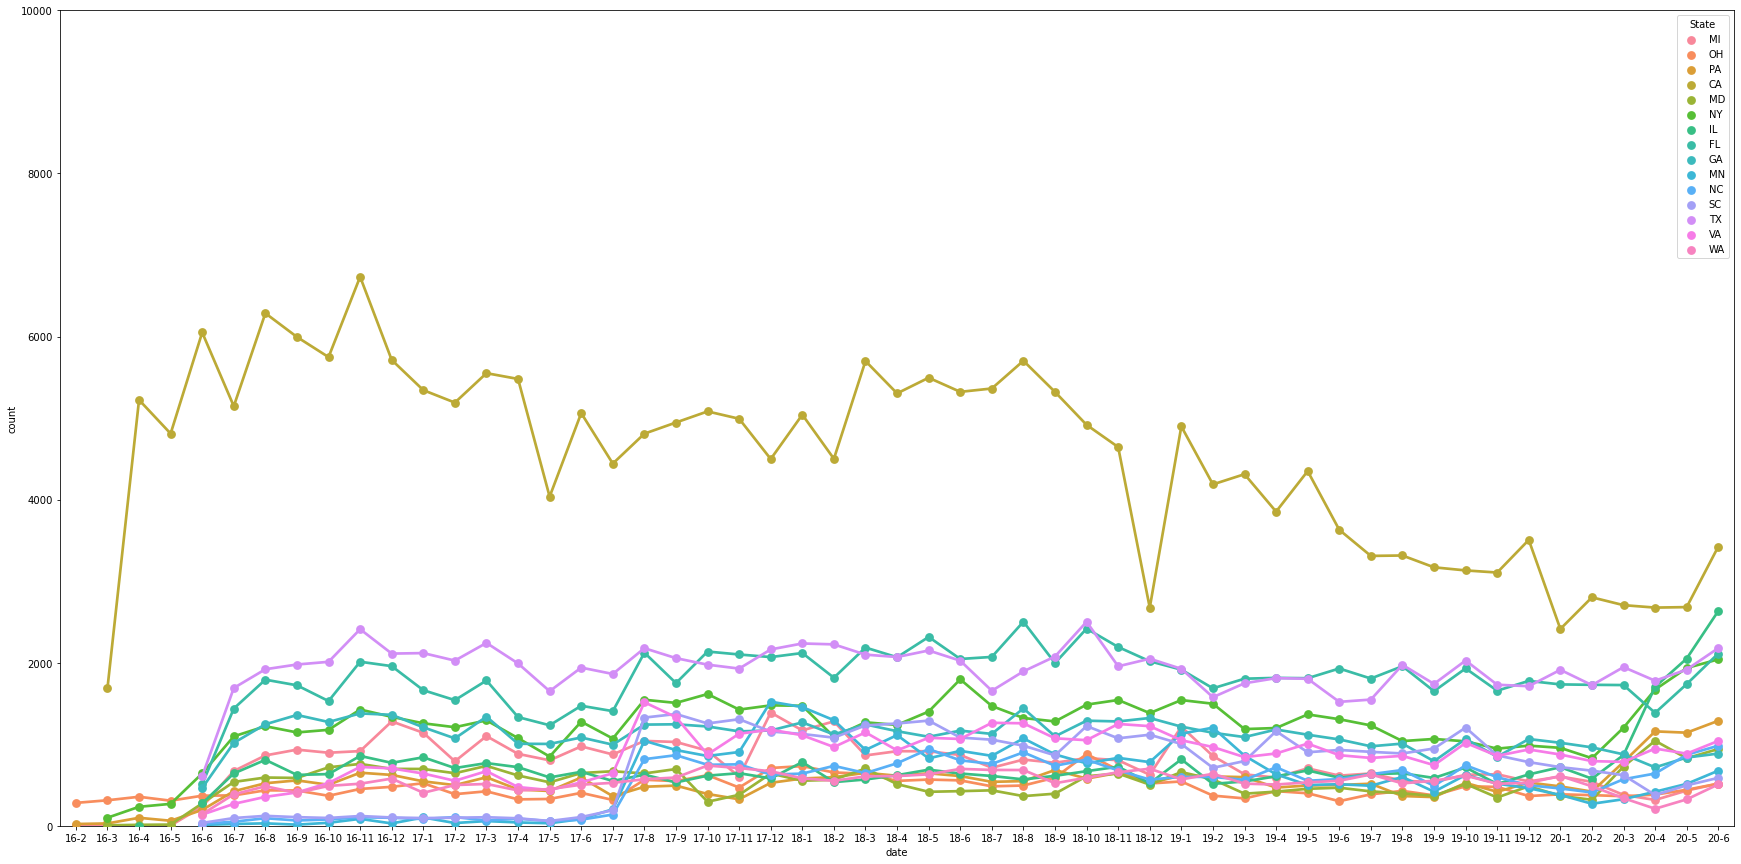

In [151]:
plt.figure(figsize=(30, 15))
sns.pointplot(data = final2, x = "date", y = 'count', hue = "State",err_style=None)
plt.ylim((0,10000))

## folium

In [154]:
import folium

In [165]:
test = final.groupby('State').ratio.mean().reset_index()

In [155]:
map = folium.Map(location=[40,-98],zoom_start=4)

In [156]:
state_geo = '../data/us-states.json'

In [179]:
map.choropleth(geo_data=state_geo,
 name='choropleth',
 data=test,
 columns=['State', 'ratio'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='ratio (%)')

C:\Users\JUNYUB\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [180]:
map